In [1]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
from scipy.sparse.linalg import splu
from scipy.linalg import lu_factor
import itertools
import time
import os
import sys
import json
import pandas as pd
import h5py 

# Import user defined libraries:
from FreeFEM import FFmatrix_fread, FFvector_fread

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_4196/2704651336.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_4196/2704651336.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


In [2]:
with open("fast phenomenon case/Fast phenomenon_parameters.json", "r") as json_file:
    parameters = json.load(json_file)

N_AVOG = parameters["N_AVOG"]  
N_BOLT = parameters["N_BOLT"]  
FISSION_ENERGY = parameters["FISSION_ENERGY"]                       
FISSION_RATE = parameters["FISSION_RATE"]                   
RADIUS = parameters["RADIUS"]
LENGTH = parameters["LENGTH"]
FISSION_YIELD = parameters["FISSION_YIELD"]                 
FUEL_THERMAL_CONDUCTIVITY = parameters["FUEL_THERMAL_CONDUCTIVITY"]
T_BC = parameters["T_BC"]  
C_BC = parameters["C_BC"]  

SOURCE_C = FISSION_RATE * FISSION_YIELD         #[atm / (m^3 s)]
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)
     
# Define reference temperature, concentration and linear diffusion parameters:
T_IC  = T_BC # [K]
C_IC = C_BC  # [atm / m^3]

TIME_FINAL = 1.00E+06  # [s]
TIME_DELTA = 2.00E+01  # [s]

# Compute number of iterations:
N_ITER = int(TIME_FINAL / TIME_DELTA)  # [-]

# Define function evaluating the concentration diffusion coefficient at given z coordinated provided the problem parameters:
def ALPHA_C(ZZ, T_BC=T_BC, GAMMA_T=GAMMA_T, FISSION_RATE=FISSION_RATE):
    return 7.60E-10 * np.exp(- 4.86E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) + \
           5.64E-25 * np.exp(- 1.91E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) * np.sqrt(FISSION_RATE) + \
           8.00E-40 * FISSION_RATE

## **FOM**

In [3]:
# Load coordinates:
coordinates_Px = FFvector_fread('mesh_utilities/vv_cc_Px.btxt')
coordinates_Pq = FFvector_fread('mesh_utilities/vv_cc_Pq.btxt')

# Identify degrees of freedom of the Px and Pq spaces:
sFO_Px = coordinates_Px.shape[0]
sFO_Pq = coordinates_Pq.shape[0]
print(rf'Degree of freedom = {sFO_Px}')

# Define vector of all Px indeces:
mask_all = np.arange(sFO_Px, dtype=int)

# Identify indeces of the top, bottom and middle boundaries in Px:
mask_inf_bc = mask_all[np.isclose([coordinates_Px[ii, 1] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_sup_bc = mask_all[np.isclose([coordinates_Px[ii, 1] for ii in range(sFO_Px)], np.ones((sFO_Px)))]
mask_mid_bc = mask_all[np.isclose([coordinates_Px[ii, 0] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_ext_bc = mask_all[np.isclose([coordinates_Px[ii, 0] for ii in range(sFO_Px)], np.ones((sFO_Px)))]

# Identify indeces of the Dirichlet b.c. for the temperature and concentration field:
mask_bc_T = np.fromiter(set(mask_sup_bc), int)
mask_bc_C = np.fromiter(set(mask_sup_bc) | set(mask_ext_bc) | set(mask_inf_bc), int)

# Identify indeces of the interior for the temperature and concentration field:
mask_in_T = [ii for ii in mask_all if ii not in mask_bc_T]
mask_in_C = [ii for ii in mask_all if ii not in mask_bc_C]

Degree of freedom = 10201


In [4]:
# Import mass matrices on the Px and on the Pq space:
mass_Px = FFmatrix_fread('mesh_utilities/ww_mm_Px.btxt')
mass_Pq = FFmatrix_fread('mesh_utilities/ww_mm_Pq.btxt')
mass_Pm = FFmatrix_fread('mesh_utilities/ww_uu_Px_Pq.btxt')

# Extract integration weights and diagonal matrix with their inverse:
weights_Pq = mass_Pq.diagonal()
project_Pq = sparse.diags(np.reciprocal(weights_Pq))

# Import map from Px to Pq and to the dx, dy, dz derivative evaluated in Pq:
PxtoPquu_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_uu_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdx_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_dx_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdy_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_dy_Px_Pq.btxt')[:, mask_in_C])

# Define weights for the integration in polar coordinates:
polar_weights_Pq = np.multiply(coordinates_Pq[:, 0], weights_Pq)

# Compute volume of the domain:
volume = np.dot(np.ones(sFO_Pq), polar_weights_Pq)

# Assemble mass matrix and projected forcing term:
forc_C = PxtoPquu_C.T.dot(polar_weights_Pq[:, None])
mass_C = PxtoPquu_C.T.dot(PxtoPquu_C.multiply(polar_weights_Pq[:, None]))
inte_C = PxtoPquu_C.T.dot(polar_weights_Pq) / volume

# Assemble a function assembling the stiffness matrix at a given time:
stiff_C = PxtoPqdx_C.T.dot(PxtoPqdx_C.multiply(ALPHA_C(coordinates_Pq[:, 1:2]) / RADIUS**2 * polar_weights_Pq[:, None])) + \
          PxtoPqdy_C.T.dot(PxtoPqdy_C.multiply(ALPHA_C(coordinates_Pq[:, 1:2]) / LENGTH**2 * polar_weights_Pq[:, None]))

In [14]:
# Funzione per eseguire la simulazione con un dato time step
def run_simulation(time_step, n_iter):
    sol_new_C = np.zeros((sFO_Px, n_iter+1))  # Reset della soluzione
    average_C = np.zeros(n_iter)  # Reset della concentrazione media

    lhs_static = mass_C + time_step * stiff_C
    lhs_static = lhs_static.toarray()  # Necessario per LU
    rhs_static = time_step * (SOURCE_C * forc_C)
    LU, PIV = sp.linalg.lu_factor(lhs_static)

    #Integrate using forward Euler up to the final time:
    for ii in range(n_iter):
        cur_time = ii * time_step

        # Stampa l'iterazione corrente e la concentrazione media
        print('Current time:', cur_time, 's')
        average_C[ii] = inte_C @ sol_new_C[mask_in_C, ii]
        print('Average concentration:', average_C[ii], 'atm/m^3\n')

        cur_rhs = mass_C.dot(sol_new_C[mask_in_C, ii:ii+1]) + rhs_static
        sol_new_C[mask_in_C, ii+1] = sp.linalg.lu_solve((LU, PIV), cur_rhs[:,0])
    
    # Print final time and final average temperature and concentration:
    print('Final time:', n_iter * time_step, 's')
    average_C[ii] = inte_C @ sol_new_C[mask_in_C, ii]
    print('Average concentration:', inte_C @ sol_new_C[mask_in_C, -1], 'atm/m^3')

    return average_C, sol_new_C

average_C, sol_new_C  = run_simulation(TIME_DELTA,N_ITER)


Current time: 0.0 s
Average concentration: 0.0 atm/m^3

Current time: 20.0 s
Average concentration: 1.7753377106906133e+20 atm/m^3

Current time: 40.0 s
Average concentration: 3.278830980341686e+20 atm/m^3

Current time: 60.0 s
Average concentration: 4.6000752831201477e+20 atm/m^3

Current time: 80.0 s
Average concentration: 5.785072100359334e+20 atm/m^3

Current time: 100.0 s
Average concentration: 6.863115495384086e+20 atm/m^3

Current time: 120.0 s
Average concentration: 7.854821902071124e+20 atm/m^3

Current time: 140.0 s
Average concentration: 8.775499852731445e+20 atm/m^3

Current time: 160.0 s
Average concentration: 9.636882978578364e+20 atm/m^3

Current time: 180.0 s
Average concentration: 1.0448152759550961e+21 atm/m^3

Current time: 200.0 s
Average concentration: 1.1216601519478568e+21 atm/m^3

Current time: 220.0 s
Average concentration: 1.1948089930821334e+21 atm/m^3

Current time: 240.0 s
Average concentration: 1.264737593584344e+21 atm/m^3

Current time: 260.0 s
Average c

KeyboardInterrupt: 

In [52]:
np.savetxt('fast phenomenon case/Fullorder_Cfield.csv', sol_new_C[:, :], delimiter=',', fmt='%d')         #Salvo il campo di concentrazione ad ogni istante di tempo
np.savetxt('fast phenomenon case/Fullorder_Caverage.csv', average_C[:], delimiter=',', fmt='%d')          #Salvo la concentrazione media ad ogni istante di tempo
#print(sol_new_C.shape)
#print(average_C.shape)

In [15]:
#Load the FOM field
sol_new_C = np.loadtxt('fast phenomenon case/Fullorder_Cfield.csv', delimiter=',')
print(sol_new_C.shape)

(10201, 50001)


In [16]:
#Chose the time analyzed 
index = 1

print(rf'Istante di tempo scelto corrisponde a dopo {TIME_DELTA*index} secondi')

Istante di tempo scelto corrisponde a dopo 20.0 secondi


6.034208587496766e+20


/Users/martina/Library/Python/3.9/lib/python/site-packages/matplotlib/tri/_triangulation.py:181: RuntimeWarning: invalid value encountered in cast
  triangles = np.asarray(triangles, dtype=np.int32)


La quota z al valore massimo della concentrazione è: 0.997277 m


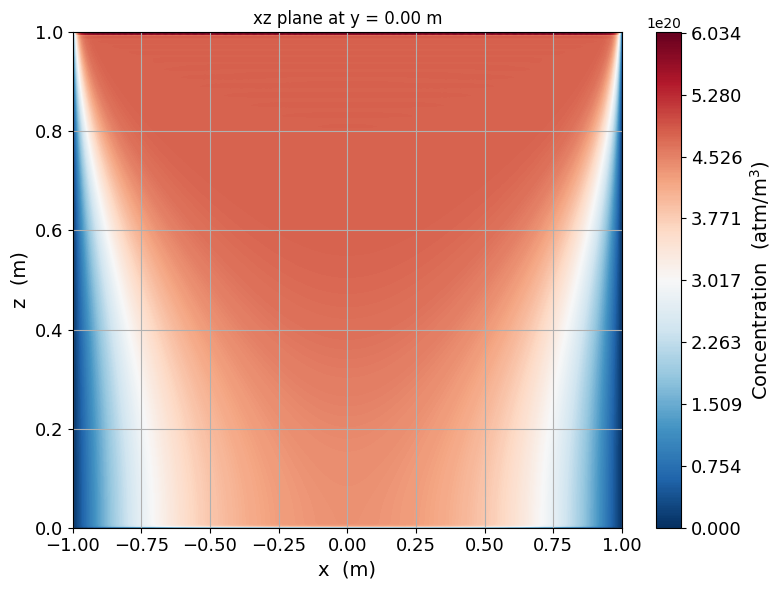

In [17]:
#sol_new_C = np.loadtxt('worst reconstructed case/Fullorder_Cfield.csv', delimiter=',')
field = sol_new_C[:, index] / volume

field = np.hstack((field, field))
coord_x = np.hstack((coordinates_Px[:, 0], - coordinates_Px[:, 0]))
coord_z = np.hstack((coordinates_Px[:, 1],   coordinates_Px[:, 1]))

#Per farlo metà
#field = sol_new_C[:, -1] / volume
#coord_x = np.hstack((coordinates_Px[:, 0]))
#coord_y = np.hstack((coordinates_Px[:, 1]))

max_tick = np.max(field)
tick_step = np.max(field)/8
print(max_tick)
ticks = np.linspace(0, max_tick, int(max_tick / tick_step) + 1)

plt.figure(figsize=(8, 6))
contour = plt.tricontourf(coord_x, coord_z, field, 400, cmap='RdBu_r', vmin=0, vmax = max_tick)
cbar = plt.colorbar(contour, ticks=ticks)       # Usa '%.2f' per due cifre decimali
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('Concentration  (atm/m$^3$)', fontsize=14)
 

#plt.ylim((1-2e-2, 1))  #zoom sulla zona ad alto gradiente
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.xlabel('x  (m)',fontsize=14)
plt.ylabel('z  (m)',fontsize=14)
plt.title('xz plane at y = 0.00 m')
plt.grid(True)
plt.tight_layout()
#plt.savefig('plot/worst reconstructed case/FOM_xz.pdf', bbox_inches='tight')

# Trova la coordinata z a cui corrisponde il valore massimo della concentrazione
max_index = np.argmax(field)  # Indice del valore massimo
z_max = coord_z[max_index]  # Coordinata z del massimo valore
print(f"La quota z al valore massimo della concentrazione è: {z_max:.6f} m")

(10201,)
6.034208587496766e+20


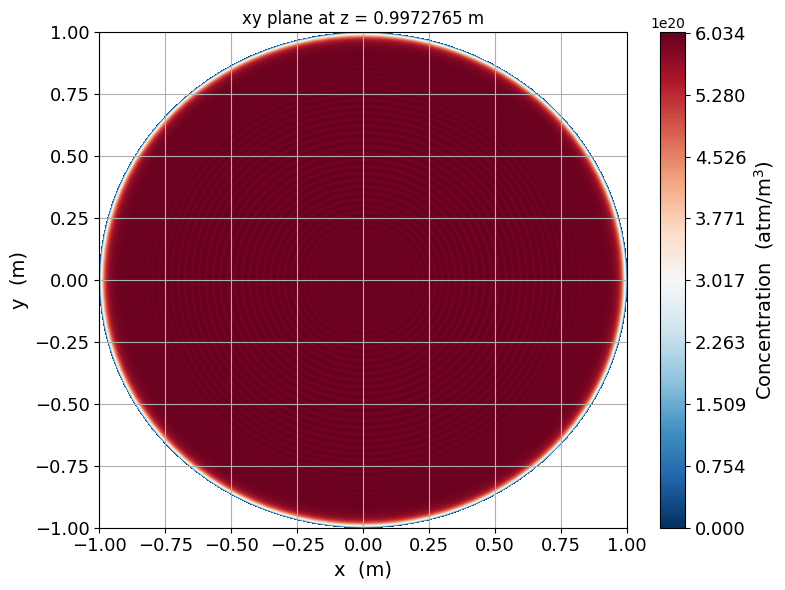

In [18]:
#sol_new_C = np.loadtxt('worst reconstructed case/Fullorder_Cfield.csv', delimiter=',')

field = sol_new_C[:, index] / volume
coord_x = np.hstack((coordinates_Px[:, 0]))
coord_z = np.hstack((coordinates_Px[:, 1]))
print(coord_x.shape)

z_target = z_max
z_tolerance = 0.0001  # tolleranza per z_target
mask = np.abs(coord_z - z_target) < z_tolerance
filtered_x = coord_x[mask]  # valori di x corrispondenti a z = 0.5
filtered_field = field[mask]  # campo in corrispondenza di z = 0.5

theta = np.linspace(0, 2 * np.pi, len(filtered_x))
r = coord_x  # assumendo che x sia la coordinata radiale
R, T = np.meshgrid(filtered_x, theta)  # griglia cilindrica
X = R * np.cos(T)  # trasformazione in X cartesiana
Y = R * np.sin(T)  # trasformazione in Y cartesiana
field_rotated = np.tile(filtered_field, (len(theta), 1))


max_tick = np.max(field)
tick_step = np.max(field)/8
print(max_tick)
ticks = np.linspace(0, max_tick, int(max_tick / tick_step) + 1)

plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, field_rotated, 400, cmap='RdBu_r', vmin = 0, vmax = max_tick)
cbar = plt.colorbar(contour, ticks=ticks)       # Usa '%.2f' per due cifre decimali
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('Concentration  (atm/m$^3$)', fontsize=14)
 
    
#plt.ylim((1-2e-2, 1))  #zoom sulla zona ad alto gradiente
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.xlabel('x  (m)',fontsize=14)
plt.ylabel('y  (m)',fontsize=14)
plt.title(rf'xy plane at z = {z_max} m')
plt.grid(True)
plt.tight_layout()
#plt.savefig('plot/worst reconstructed case/FOM_xy.pdf', bbox_inches='tight')

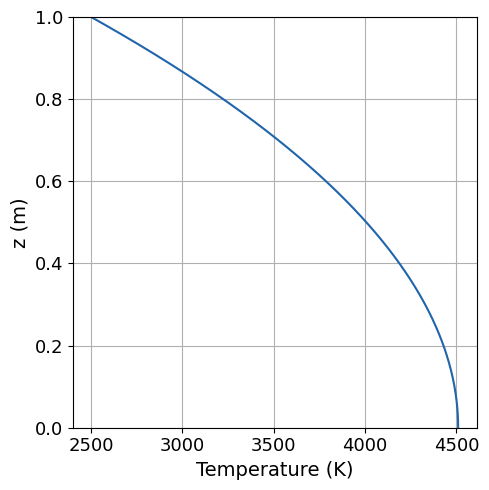

In [15]:
#OpenFOAM=pd.read_csv("data/OpenFOAM_Tprofile.csv")     

cmap = plt.get_cmap('RdBu')
color = cmap(0.9)

total_layers = list(set(coordinates_Px[:,1]))
all_layers = sorted(list(set(coordinates_Px[:, 1])))
effective_layers = np.linspace(all_layers[0], all_layers[-1], 5)  # Livelli da etichettare


fig, (ax1) = plt.subplots(1, figsize=(5,5))
#ax1.plot(OpenFOAM.iloc[:, 0], OpenFOAM.iloc[:, -1], label = 'OpenFOAM', color='#FF7F50', linewidth=1.5)
ax1.plot( T_BC + GAMMA_T * (1 - np.linspace(0,1 ,1001)**2) / 2, np.linspace(0,1,1001),label = '$T_\infty$', color=color, linewidth=1.5)
ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)
#ax1.set_yticks(all_layers)  # Mostra tutti i tick
#ax1.set_yticklabels(
#    [f"{layer:.2f}" if layer in effective_layers else "" for layer in all_layers],
#    fontsize=13
#)  # Etichetta solo i livelli scelti, lasciando vuoti gli altri

ax1.set_ylim([0, 1])
#ax1.set_xlim([2000, 2250])
ax1.set_ylabel('z (m)',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.grid()
plt.tight_layout()
#plt.savefig('plot/worst reconstructed case/Temperature profile.pdf', bbox_inches='tight') 

#ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=2, fontsize=13)

#error = ((np.abs((OpenFOAM.iloc[:, 0]-(T_BC + GAMMA_T * (1 - np.linspace(0, 1,1001)**2) / 2))))/OpenFOAM.iloc[:, 0])*100
#print(np.max(error))

## ROM SOLUTION

In [19]:
# Apri il file in modalità lettura
with h5py.File('checkpoint/step_190/matrici_RB.h5', 'r') as hf:
    # Accedi ai dataset e ricrea le matrici
    MM_RB = hf['MM_RB'][:]
    FF_RB = hf['FF_RB'][:]
    KK_RB = hf['KK_RB'][:]
    AA_RB = hf['AA_RB'][:]
    ZZ_CO = hf['ZZ_CO'][:]
    II_CO = hf['II_CO'][:]
    basis = hf['basis'][:]

print(basis.shape)
n_dofs = coordinates_Px.shape[0]
n_cols = basis.shape[1]
basis_extended = np.zeros((n_dofs, n_cols))
basis_extended[mask_in_C, :] = basis
print(basis_extended.shape)

(9900, 190)
(10201, 190)


In [20]:
TT = T_BC + GAMMA_T * (1 - ZZ_CO**2) / 2

#SCIANTIX userà il modello scelto dall'utente 
WW = 7.60E-10 * np.exp(- 4.86E-19 / (TT * 1.380649E-23)) +\
     5.64E-25 * np.exp(- 1.91E-19 / (TT * 1.380649E-23)) * np.sqrt(FISSION_RATE) +\
     8.00E-40 * FISSION_RATE
 
CC_CO = np.hstack((II_CO @ WW / RADIUS**2, II_CO @ WW / LENGTH**2))
 
SS_RB = np.tensordot(CC_CO, KK_RB, axes=[0, 0])
QQ_RB = SOURCE_C * FF_RB
 
LHS_RB_static = MM_RB + TIME_DELTA * SS_RB #matrice + matrice * scalare. Avendo il termine MM_RB al lhs è forward euler, se invece fosse nel RHS sarebbe Backward. 
RHS_RB_static = TIME_DELTA * QQ_RB         #vettore per scalare
LU, PIV = sp.linalg.lu_factor(LHS_RB_static)

old_sol_RB = np.zeros((MM_RB.shape[0], 1))
reconstructed_solution = np.zeros((1000))
for ii in range(index):
    old_sol_RB = sp.linalg.lu_solve((LU, PIV), RHS_RB_static + MM_RB.dot(old_sol_RB))
    value = np.dot(AA_RB, old_sol_RB)[0]
    reconstructed_solution[ii] = value
    print(reconstructed_solution[ii])

reconstructed_field = np.dot(basis_extended, old_sol_RB[:,0])
print(reconstructed_field.shape)
#np.savetxt('worst reconstructed case/Reconstructed_field_reference.csv', reconstructed_field, delimiter=',', fmt='%d')

1.7753353512920216e+20
(10201,)


3.012917630899655e+20
La quota z al valore massimo della concentrazione è: 0.997277 m


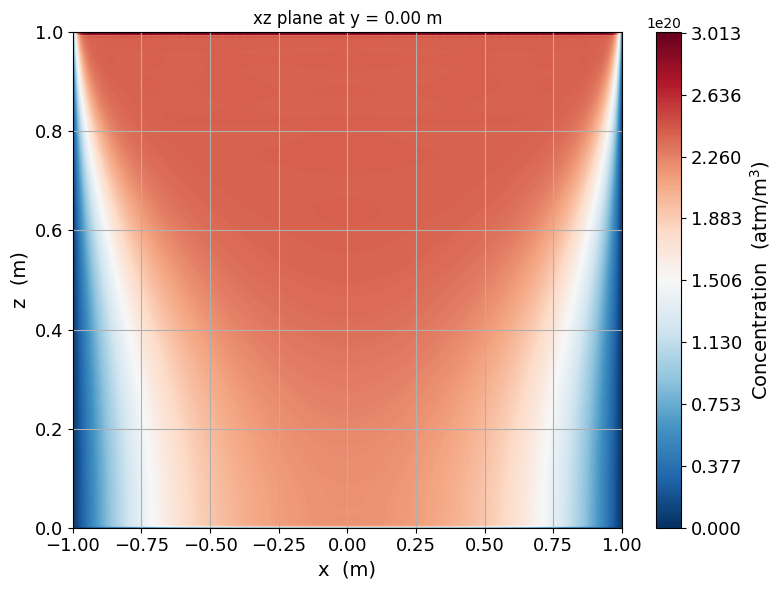

In [21]:
#sol_new_C = np.loadtxt('worst reconstructed case/Fullorder_Cfield.csv', delimiter=',')
field = reconstructed_field

field = np.hstack((field, field))
coord_x = np.hstack((coordinates_Px[:, 0], - coordinates_Px[:, 0]))
coord_z = np.hstack((coordinates_Px[:, 1],   coordinates_Px[:, 1]))

#Per farlo metà
#field = sol_new_C[:, -1] / volume
#coord_x = np.hstack((coordinates_Px[:, 0]))
#coord_y = np.hstack((coordinates_Px[:, 1]))

max_tick = np.max(field)
tick_step = np.max(field)/8
print(max_tick)
ticks = np.linspace(0, max_tick, int(max_tick / tick_step) + 1)

plt.figure(figsize=(8, 6))
contour = plt.tricontourf(coord_x, coord_z, field, 400, cmap='RdBu_r', vmin=0, vmax = max_tick)
cbar = plt.colorbar(contour, ticks=ticks)       # Usa '%.2f' per due cifre decimali
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('Concentration  (atm/m$^3$)', fontsize=14)
 

#plt.ylim((1-2e-2, 1))  #zoom sulla zona ad alto gradiente
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.xlabel('x  (m)',fontsize=14)
plt.ylabel('z  (m)',fontsize=14)
plt.title('xz plane at y = 0.00 m')
plt.grid(True)
plt.tight_layout()
#plt.savefig('plot/worst reconstructed case/FOM_xz.pdf', bbox_inches='tight')

# Trova la coordinata z a cui corrisponde il valore massimo della concentrazione
max_index = np.argmax(field)  # Indice del valore massimo
z_max = coord_z[max_index]  # Coordinata z del massimo valore
print(f"La quota z al valore massimo della concentrazione è: {z_max:.6f} m")

In [13]:
#Errore punto per punto normalizzato rispetto al full order model -> errore locale 
FOM = sol_new_C[:, index]
ROM = reconstructed_field 
print(rf'Dimensione di FOM = {FOM.shape}')
print(rf'Dimensione di ROM = {ROM.shape}')

FOM_minus_ROM = np.abs(FOM - ROM)
print(rf'Dimensione di FOM-ROM = {FOM_minus_ROM.shape}')
print(rf'Massimo differenza tra FOM-ROM = {np.max(FOM_minus_ROM)}')

FOM_minus_ROM = np.abs(FOM - ROM)/np.max(np.abs(FOM))
print(rf'Massima differenza relativo tra FOM-ROM = {np.max(FOM_minus_ROM)}')

Dimensione di FOM = (9900,)
Dimensione di ROM = (10201,)


ValueError: operands could not be broadcast together with shapes (9900,) (10201,) 

In [11]:
# Errore assoluto usando la norma euclidea -> errore globale. 
ABS_ERR = np.linalg.norm(FOM - ROM, axis=0) 
REL_ERR = ABS_ERR / np.linalg.norm(sol_new_C[:, 2], axis=0)
print(rf'Massimo errore relativo = {REL_ERR}')

Massimo errore relativo = 0.0005174916276762296


0.018971962103466085


ValueError: z array must have same length as triangulation x and y arrays

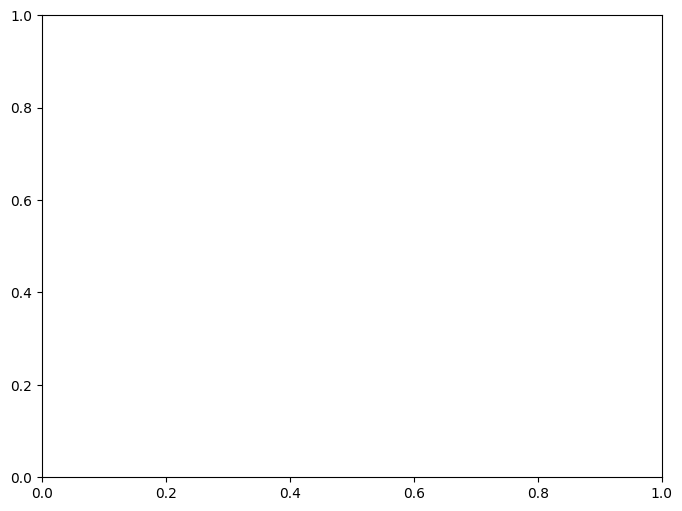

In [12]:
field = np.hstack((FOM_minus_ROM, FOM_minus_ROM))
coord_x = np.hstack((coordinates_Px[:, 0], - coordinates_Px[:, 0]))
coord_z = np.hstack((coordinates_Px[:, 1],   coordinates_Px[:, 1]))

max_tick = np.max(field)
tick_step = max_tick/10
print(max_tick)
ticks = np.linspace(0, max_tick, int(max_tick / tick_step) + 1)


plt.figure(figsize=(8, 6))
contour = plt.tricontourf(coord_x, coord_z, field, 400, cmap='RdBu_r', vmin=0, vmax = max_tick)
cbar = plt.colorbar(contour, ticks=ticks)       # Usa '%.2f' per due cifre decimali
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('FOM-ROM/FOM', fontsize=14)

plt.title(f'xz plane at y = {0.00} m')
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.xlabel('x (m)',fontsize=14)
plt.ylabel('z (m)',fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('plot/worst reconstructed case/FOM-ROM.pdf', bbox_inches='tight') 

## **L2 error**

In [22]:
from solver_class import FiniteElementCylinderSolver, ReducedBasisCylinderSolver

Average concentration FOM: 1.3689025182469833e+22
Average concentration ROM: 1.3689025136787055e+22


/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_4036/2153071588.py:40: RuntimeWarning: invalid value encountered in scalar divide
  L2_normalized[ii] = L2_norm / reference_norm # 1


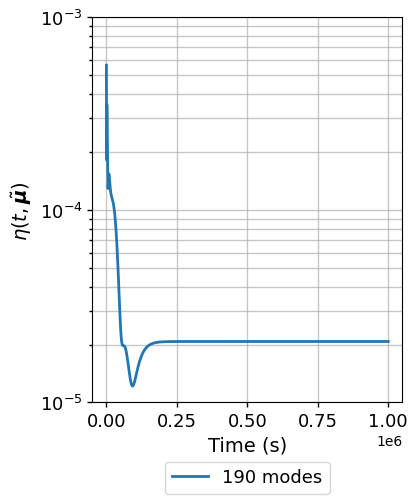

In [ ]:
MM_FO = np.load('model_files/XX_FO.npy', allow_pickle=True)[0]  # Matrice per norma L2 
with open("fast phenomenon case/Fast phenomenon_parameters.json", "r") as json_file:
    parameters = json.load(json_file)
                 
cur_FR = parameters["FISSION_RATE"]                   
cur_RR = parameters["RADIUS"]
cur_LL = parameters["LENGTH"]
cur_FY = parameters["FISSION_YIELD"]                 
cur_K = parameters["FUEL_THERMAL_CONDUCTIVITY"]
cur_BC = parameters["T_BC"] 
t_final = 1.00E+06  # [s] 
cur_dt = 2.00E+01  # [s]
num_time_steps = int(t_final / cur_dt)  # [-]

with h5py.File('checkpoint/step_190/matrici_RB.h5', 'r') as hf:
        basis = hf['basis'][:]

L2_normalized = np.zeros(num_time_steps)

# Calcola la soluzione FOM con i parametri attuali
solver_FO = FiniteElementCylinderSolver()
solver_FO.assemble(RADIUS=cur_RR, LENGTH=cur_LL, F_RATE=cur_FR, 
                F_YIELD=cur_FY, T_BC=cur_BC, KTH=cur_K, dt=cur_dt)
solution_FO = solver_FO.solve(n_steps=num_time_steps, verbose=False)         #(9900, 1001)
print(f'Average concentration FOM: {inte_C @ solution_FO[:, -1]}')

# Calcola la soluzione ROM
solver_RB = ReducedBasisCylinderSolver(basis[:, :])
solver_RB.assemble(RADIUS=cur_RR, LENGTH=cur_LL, F_RATE=cur_FR, 
                F_YIELD=cur_FY, T_BC=cur_BC, KTH=cur_K, dt=cur_dt)
solution_RB = solver_RB.solve(n_steps=num_time_steps, error_bound=False)     #(173,1001)
solution_RB = np.dot(basis, solution_RB[:, :])                               #(9900, 1001)
print(f'Average concentration ROM: {inte_C @ solution_RB[:, -1]}')


for ii in range(0, num_time_steps):
    difference = solution_FO[:, ii] - solution_RB[:, ii]
    L2_norm = np.sqrt(MM_FO.dot(difference).dot(difference)) #1
    reference_norm = np.sqrt(MM_FO.dot(solution_FO[:, ii]).dot(solution_FO[:, ii])) #1
    L2_normalized[ii] = L2_norm / reference_norm # 1



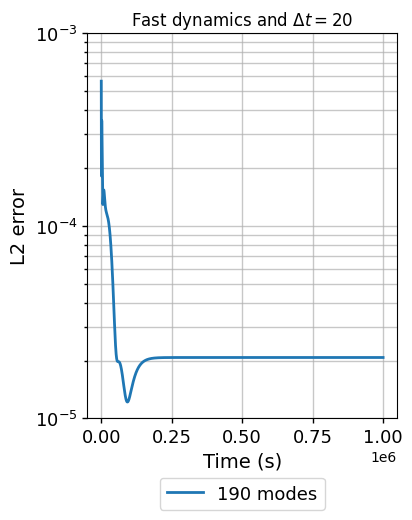

In [32]:
fig, (ax1) = plt.subplots(1, figsize=(4,5))
ax1.set_yscale('log')
ax1.plot(np.linspace(0, t_final, num_time_steps),L2_normalized, label='190 modes', linewidth = 2)
ax1.tick_params(axis="y", which='both',labelsize=13,  width=1)
ax1.tick_params(axis='x', labelsize=13,  width=1)
ax1.set_xlabel('Time (s)',fontsize=14)
ax1.set_ylabel(r'L2 error',fontsize=14)
#ax1.set_xlim([0,1e7])
ax1.set_ylim([1e-5, 1e-3])
ax1.set_title(rf'Fast dynamics and $\Delta t = 20$')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=3, fontsize=13)
ax1.grid(visible=True, which='both', linewidth=1, alpha=0.7)
#plt.savefig('plot/L2error_in_time.pdf', bbox_inches='tight') 